In [1]:
from torchvision.transforms import transforms
from torch.utils.data       import DataLoader,Dataset
from torchvision            import datasets
import torchvision.models   as models
import torch.nn.functional  as F
import torch.nn             as nn
import torch,torchvision
from torchvision.transforms import ToTensor, ToPILImage, Lambda


from torch.autograd import Variable
import string
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os,PIL,random,pathlib
import matplotlib.pyplot as plt
import pandas as pd

# 标注文件地址
annotation_path = r'14_traffic_sign/annotations.csv'

os.environ['KMP_DUPLICATE_LIB_OK']='True' # 解决jupyter运行挂内核问题



data_dir = r'14_traffic_sign/images'
data_dir = pathlib.Path(data_dir)


data_paths     = list(data_dir.glob('*'))

fileNames = [str(path).split("/")[2] for path in data_paths][:10]
print(fileNames)

['000_0001.png', '000_0001_j.png', '000_0002.png', '000_0002_j.png', '000_0003.png', '000_0003_j.png', '000_0004.png', '000_0004_j.png', '000_0005.png', '000_0005_j.png']


In [3]:
pictures_paths = list(data_dir.glob('*'))
pictures_paths = [str(path) for path in pictures_paths]
pictures_paths[:3]

['14_traffic_sign/images/000_0001.png',
 '14_traffic_sign/images/000_0001_j.png',
 '14_traffic_sign/images/000_0002.png']

In [4]:
labels = pd.read_csv(annotation_path)
labels.iloc[:,1].unique() # 共58类

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

(81, 70, 3)


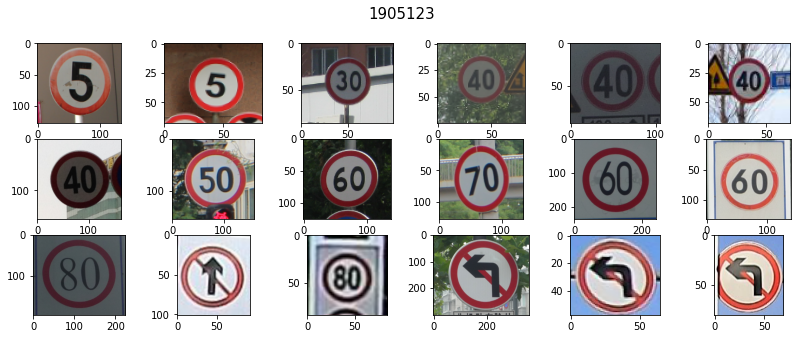

In [91]:
img_class_num = 58
plt.figure(figsize=(14,5))
plt.suptitle("1905123",fontsize=15)
for i in range(18):
    plt.subplot(3,6,i+1)
    # plt.xticks([])
    # plt.yticks([])
    # plt.grid(False)
    
    # 显示图片
    images = plt.imread(pictures_paths[i*100])
    
    plt.imshow(images)
# print(images.shape)

plt.show()

In [6]:
temp = (0,0,0)
for i in range(10000):   #查看图片大小
    a = plt.imread(pictures_paths[10]).shape
    if a[1]>temp[1] and a[0]>temp[0]:
        temp=a
temp

(108, 123, 3)

In [7]:
# import cv2
class Rotation(object):
    '''旋转图片'''
    def __init__(self, angle=5, fill_value=0, p = 0.5):
        self.angle = angle
        self.fill_value = fill_value
        self.p = p

    def __call__(self, sample):
        print(sample)
        if np.random.uniform(0.0, 1.0) < self.p:
            return sample
        h,w,_ = sample.shape
        ang_rot = np.random.uniform(self.angle) - self.angle/2
        transform = cv2.getRotationMatrix2D((w/2, h/2), ang_rot, 1)
        sample = cv2.warpAffine(sample, transform, (w,h), borderValue = self.fill_value)
        return sample

class Translation(object):
    def __init__(self, fill_value=0, p = 0.5):
        self.fill_value = fill_value
        self.p = p

    def __call__(self, sample):
        if np.random.uniform(0.0, 1.0) < self.p:
            return sample
        h,w,_ = sample.shape
        trans_range = [w / 10, h / 10]
        tr_x = trans_range[0]*np.random.uniform()-trans_range[0]/2
        tr_y = trans_range[1]*np.random.uniform()-trans_range[1]/2
        transform = np.float32([[1,0, tr_x], [0,1, tr_y]])
        sample = cv2.warpAffine(sample, transform, (w,h), borderValue = self.fill_value)
        return sample
    
class StepLR(object):
    '''学习率递减'''
    def __init__(self, optimizer, step_size=1000, max_iter=10000):
        self.optimizer = optimizer
        self.max_iter = max_iter
        self.step_size = step_size
        self.last_iter = -1
        self.base_lrs = list(map(lambda group: group['lr'], optimizer.param_groups))

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def step(self, last_iter=None):
        if last_iter is not None:
            self.last_iter = last_iter
        if self.last_iter + 1 == self.max_iter:
            self.last_iter = -1
        self.last_iter = (self.last_iter + 1) % self.max_iter
        for ids, param_group in enumerate(self.optimizer.param_groups):
            param_group['lr'] = self.base_lrs[ids] * 0.8 ** ( self.last_iter // self.step_size )

In [8]:
total_datadir = r'14_traffic_sign/images'

# 关于transforms.Compose的更多介绍可以参考：https://blog.csdn.net/qq_38251616/article/details/124878863
train_transforms = transforms.Compose([
    transforms.Resize([100, 100]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std =[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])


# dataSet

In [9]:
class ImgDataset(Dataset):
    def __init__(self, label_file, img_dir, transform=None, target_transform=None):
        # 标签目录
        self.labels = pd.read_csv(label_file)
        # 图片文件目录
        self.img_dir = img_dir
        #tranform
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        '''返回数据的样本数'''
        return len(self.labels)
    
    def __getitem__(self, index):
        '''获取数据'''
        img_path = os.path.join(self.img_dir, self.labels.iloc[index,0])
        
        # 读取图片
        image = PIL.Image.open(img_path)
        # 获取图片对应的标签，1表示Excel文件的第二列
        y_label = int(self.labels.iloc[index, 1])
        # 如果使用时附加了transform参数，则对图片、标签应用转换
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            y_label = self.target_transform(y_label)
        
        return image, y_label

In [10]:
total_data = ImgDataset(label_file=annotation_path,img_dir=data_dir,transform=train_transforms,
                        target_transform=Lambda(lambda y: torch.zeros(img_class_num, 
                                                                      dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))
print('one-hot标签：',total_data[0][0].shape)


one-hot标签： torch.Size([3, 100, 100])


In [11]:
train_size = int(0.8 * total_data.__len__())
test_size  = len(total_data) - train_size
total_data
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7fbee26e67c0>,
 <torch.utils.data.dataset.Subset at 0x7fbee0184f10>)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=48,
                                           shuffle=True,
                                           num_workers=0)# Windows下把num_work设置为0，否者会被阻塞
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=48,
                                          shuffle=True,
                                          num_workers=0)

print("The number of images in a training set is: ", len(train_loader)*16)
print("The number of images in a test set is: ", len(test_loader)*16)
print("The number of batches per epoch is: ", len(train_loader))

The number of images in a training set is:  1648
The number of images in a test set is:  416
The number of batches per epoch is:  103


In [13]:
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([48, 3, 100, 100])
Shape of y:  torch.Size([48, 58]) torch.float32


# 模型保存与加载模块

In [14]:
from torch import optim

import click
import string
from tqdm import tqdm, tqdm_notebook
from torchvision.transforms import Compose
from torch.nn import CrossEntropyLoss
import editdistance

In [15]:
from collections import OrderedDict

import torch
from torch import nn

def load_weights(target, source_state):
    new_dict = OrderedDict()
    for k, v in target.state_dict().items():
        if k in source_state and v.size() == source_state[k].size():
            new_dict[k] = source_state[k]
        else:
            new_dict[k] = v
    target.load_state_dict(new_dict)

def load_model( seq_proj=[0, 0], backend='resnet18', snapshot=None, cuda=True):
    net = CRNN(seq_proj=seq_proj, backend=backend)
    # net = nn.DataParallel(net)
    if snapshot is not None:
        load_weights(net, torch.load(snapshot))
    if cuda:
        net = net.cuda()
    return net

## 测试模块

In [33]:

def test(net, dataloader,cuda):
    data_loader = dataloader
    
    count = 0
    tp = 0
    avg_ed = 0
    iterator = tqdm(data_loader)
    for sample in iterator:
        imgs = Variable(sample[0])
        if cuda:
            imgs = imgs.cuda()
        out = net(imgs, decode=True)
        labels = Variable(sample[1]).argmax(axis=-1).cuda()
        # print(out)
        # print(labels[0])
#         gt = (sample["seq"].numpy() - 1).tolist()
#         lens = sample["seq_len"].numpy().tolist()
#         pos = 0
#         key = ''
        for i in range(len(out)):
#             gts = ''.join(abc[c] for c in gt[pos:pos+lens[i]])
#             pos += lens[i]
            if labels[i] == out[i]:
                tp += 1
            else:
                avg_ed += editdistance.eval([out[i]], [labels[i]])
            count += 1
        iterator.set_description("acc: {0:.4f}; avg_ed: {0:.4f}".format(tp / count, avg_ed / count))

    acc = tp / count
    avg_ed = avg_ed / count
    return acc, avg_ed

# 模型创建

## resnet

In [27]:
class resNet(nn.Module):
    def __init__(self,
                 num_classes=58,
                 backend='resnet18',
                 rnn_hidden_size=64,
                 rnn_num_layers=1,
                 rnn_dropout=0,
                 seq_proj=[0, 0]):
        super(resNet, self).__init__()

        self.num_classes = num_classes

        self.feature_extractor = getattr(models, backend)(pretrained=True) #加载预训练模型
        self.cnn = nn.Sequential(
            self.feature_extractor.conv1,
            self.feature_extractor.bn1,
            self.feature_extractor.relu,
            self.feature_extractor.maxpool,
            self.feature_extractor.layer1,
            self.feature_extractor.layer2,
            self.feature_extractor.layer3,
            self.feature_extractor.layer4
        )

        
        self.linear1 = nn.Linear(self.get_block_size(self.cnn)*16, self.get_block_size(self.cnn))
        self.linear2 = nn.Linear(self.get_block_size(self.cnn), self.num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, decode=False):
#         print(x.shape)
        features = self.cnn(x)
#         print(features.shape)
        features = features.view(-1,self.get_block_size(self.cnn)*16)
        features = self.linear1(features)
        features = self.linear2(self.relu(features))
        if not self.training:
            features = self.softmax(features)
            if decode:
                features = self.decode(features)
        return features

    def init_hidden(self, batch_size, gpu=False):
        h0 = Variable(torch.zeros( self.rnn_num_layers * 2,
                                   batch_size,
                                   self.rnn_hidden_size))
        if gpu:
            h0 = h0.cuda()
        return h0

    def features_to_sequence(self, features):
        features = features.mean(2)
        b, c, w = features.size()
        features = features.reshape(b, c, 1, w)
        b, c, h, w = features.size()
        # print(b, c, h, w)
        assert h == 1, "the height of out must be 1"
        if not self.fully_conv:
            features = features.permute(0, 3, 2, 1)
            features = self.proj(features)
            features = features.permute(1, 0, 2, 3)
        else:
            features = features.permute(3, 0, 2, 1)
        features = features.squeeze(2)
        return features

    def get_block_size(self, layer):
        return layer[-1][-1].bn2.weight.size()[0]

    def decode(self, pred):
        '''输出类别下标'''
        seq = []
        for i in range(pred.shape[0]):
            seq.append(pred[i].argmax(axis=-1))
        return seq

### 训练

In [18]:
res_acc=[]
res_loss=[]

In [60]:
def main(
         seq_proj="4x1", 
         backend="resnet18",
         snapshot=None, 
         input_size="100x100",
         base_lr=1e-3,
         step_size=1000,
         max_iter=10000,
         batch_size=128,
         output_dir='./',
         test_epoch=1,
         test_init=None, 
         gpu='0'):
    
#     os.environ["CUDA_VISIBLE_DEVICES"] = gpu
#     cuda = True if gpu is not '0' else False
    cuda = True

    input_size = [int(x) for x in input_size.split('x')] # 图片尺寸

    data = total_data
    data_val = test_dataset
    
    data_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0)# Windows下把num_work设置为0，否者会被阻塞
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

    
    seq_proj = [int(x) for x in seq_proj.split('x')]
    
    net = resNet()
    if cuda:
        net = net.cuda()
    optimizer = optim.Adam(net.parameters(), lr = base_lr, weight_decay=0.0001)
    lr_scheduler = StepLR(optimizer, step_size=step_size, max_iter=max_iter)
    loss_function = CrossEntropyLoss()

    acc_best = 0
    epoch_count = 0
    while (epoch_count < 10):
        if (test_epoch is not None and epoch_count != 0 and epoch_count % test_epoch == 0) or (test_init and epoch_count == 0):
            print("Test phase")
#             data.set_mode("test")
            net = net.eval()
            acc, avg_ed = test(net, test_loader, cuda)
            net = net.train()
#             data.set_mode("train")
            if acc > acc_best:
                if output_dir is not None:
                    torch.save(net.state_dict(), os.path.join(output_dir, "crnn_" + backend + "_"  + "_best"))
                acc_best = acc
            
            res_acc.append(acc)# 记录正确率
            print("acc: {}\tacc_best: {}; avg_ed: {}".format(acc, acc_best, avg_ed))

        

        loss_mean = []
        iterator = tqdm(data_loader)
        iter_count = 0
        for sample in iterator:
            # for multi-gpu support
#             print(len(sample))
#             sample = torch.Tensor(sample)
#             print(sample.shape)
#             break
#             if sample.shape[0] % len(gpu.split(',')) != 0:
#                 continue
            optimizer.zero_grad()
            imgs = Variable(sample[0])
            labels = Variable(sample[1]).cuda()
#             label_lens = Variable(sample["seq_len"].int())
            if cuda:
                imgs = imgs.cuda()
            preds = net(imgs).cuda()
            pred_lens = Variable(torch.Tensor([preds.size(0)] * batch_size).int())
            
            # print(preds.shape, labels.shape)
#             print(labels.shape)
#             print(preds.shape)
            labels=labels.argmax(axis=-1).long()
            loss = loss_function(preds, labels)
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), 10.0)
            loss_mean.append(loss.item())
            # 记录损失
            # print(loss.item())
            res_loss.append(loss.item())
            status = "epoch: {}; iter: {}; lr: {}; loss_mean: {}; loss: {}".format(epoch_count, lr_scheduler.last_iter, lr_scheduler.get_lr(), np.mean(loss_mean), loss.item())
            iterator.set_description(status)
            optimizer.step()
            lr_scheduler.step()
            iter_count += 1
        
        if output_dir is not None:
            torch.save(net.state_dict(), os.path.join(output_dir, "crnn_" + backend + "_"  + "_last"))
        epoch_count += 1

    return 1

if __name__ == '__main__':
    main()

  0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipykernel_2174/3894296217.py:90: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), 10.0)
epoch: 0; iter: 37; lr: 0.001; loss_mean: 1.5733347191260412; loss: 0.6215221285820007: 100%|██████████| 39/39 [00:12<00:00,  3.18it/s] 


Test phase


acc: 0.8427; avg_ed: 0.8427: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


acc: 0.8426601784266018	acc_best: 0.8426601784266018; avg_ed: 0.1573398215733982


epoch: 1; iter: 76; lr: 0.001; loss_mean: 0.32036726100322527; loss: 0.41028720140457153: 100%|██████████| 39/39 [00:12<00:00,  3.15it/s]


Test phase


acc: 0.9278; avg_ed: 0.9278: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


acc: 0.9278183292781833	acc_best: 0.9278183292781833; avg_ed: 0.07218167072181671


epoch: 2; iter: 115; lr: 0.001; loss_mean: 0.1462875971904932; loss: 0.22456052899360657: 100%|██████████| 39/39 [00:12<00:00,  3.17it/s]  


Test phase


acc: 0.9440; avg_ed: 0.9440: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


acc: 0.9440389294403893	acc_best: 0.9440389294403893; avg_ed: 0.05596107055961071


epoch: 3; iter: 154; lr: 0.001; loss_mean: 0.12735167546914175; loss: 0.3597070276737213: 100%|██████████| 39/39 [00:12<00:00,  3.11it/s]  


Test phase


acc: 0.8767; avg_ed: 0.8767: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


acc: 0.8767234387672344	acc_best: 0.9440389294403893; avg_ed: 0.12327656123276562


epoch: 4; iter: 193; lr: 0.001; loss_mean: 0.09099179305709325; loss: 0.03154724836349487: 100%|██████████| 39/39 [00:12<00:00,  3.04it/s] 


Test phase


acc: 0.9732; avg_ed: 0.9732: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


acc: 0.9732360097323601	acc_best: 0.9732360097323601; avg_ed: 0.0267639902676399


epoch: 5; iter: 232; lr: 0.001; loss_mean: 0.032893754047108814; loss: 0.0635790303349495: 100%|██████████| 39/39 [00:12<00:00,  3.15it/s]   


Test phase


acc: 0.9854; avg_ed: 0.9854: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


acc: 0.9854014598540146	acc_best: 0.9854014598540146; avg_ed: 0.014598540145985401


epoch: 6; iter: 271; lr: 0.001; loss_mean: 0.021495173200935077; loss: 0.006179353222250938: 100%|██████████| 39/39 [00:12<00:00,  3.13it/s] 


Test phase


acc: 0.9724; avg_ed: 0.9724: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


acc: 0.9724249797242498	acc_best: 0.9854014598540146; avg_ed: 0.027575020275750203


epoch: 7; iter: 310; lr: 0.001; loss_mean: 0.03575705874633665; loss: 0.06311624497175217: 100%|██████████| 39/39 [00:12<00:00,  3.16it/s]   


Test phase


acc: 0.9643; avg_ed: 0.9643: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


acc: 0.9643146796431468	acc_best: 0.9854014598540146; avg_ed: 0.035685320356853206


epoch: 8; iter: 349; lr: 0.001; loss_mean: 0.03384183261256952; loss: 0.013587494380772114: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s] 


Test phase


acc: 0.9781; avg_ed: 0.9781: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


acc: 0.9781021897810219	acc_best: 0.9854014598540146; avg_ed: 0.021897810218978103


epoch: 9; iter: 388; lr: 0.001; loss_mean: 0.0708094861310644; loss: 0.06260931491851807: 100%|██████████| 39/39 [00:12<00:00,  3.17it/s]  


Text(0.5, 1.0, 'accuracy')

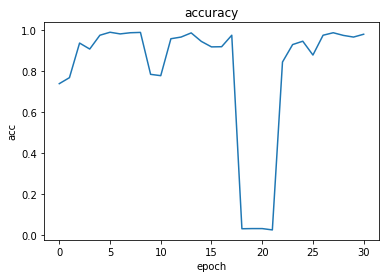

In [82]:
plt.plot(res_acc)
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

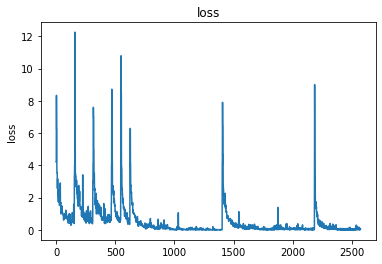

In [83]:
a = torch.tensor(res_loss)
a = a.cpu()
plt.plot(a)
plt.ylabel("loss")
plt.title('loss')

In [80]:
np.max(res_acc)

0.9878345498783455

## CRNN resnet + GRU 

In [71]:
class CRNN(nn.Module):
    def __init__(self,
                 num_classes=58,
                 backend='resnet18',
                 rnn_hidden_size=64,
                 rnn_num_layers=1,
                 rnn_dropout=0,
                 seq_proj=[0, 0]):
        super(CRNN, self).__init__()

        self.num_classes = num_classes

        self.feature_extractor = getattr(models, backend)(pretrained=True) #加载预训练模型
        self.cnn = nn.Sequential(
            self.feature_extractor.conv1,
            self.feature_extractor.bn1,
            self.feature_extractor.relu,
            self.feature_extractor.maxpool,
            self.feature_extractor.layer1,
            self.feature_extractor.layer2,
            self.feature_extractor.layer3,
            self.feature_extractor.layer4
        )

        self.fully_conv = seq_proj[0] == 0
        if not self.fully_conv:
            self.proj = nn.Conv2d(seq_proj[0], seq_proj[1], kernel_size=1)

        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.rnn = nn.GRU(self.get_block_size(self.cnn),
                          rnn_hidden_size, rnn_num_layers,
                          batch_first=False,
                          dropout=rnn_dropout, bidirectional=True) # GRU
        self.linear = nn.Linear(rnn_hidden_size * 2, self.num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, decode=False):
        hidden = self.init_hidden(x.size(0), next(self.parameters()).is_cuda)
        features = self.cnn(x)
        features = self.features_to_sequence(features)
        seq, hidden = self.rnn(features, hidden)
        seq = self.linear(seq)
        seq = seq.squeeze(0)
        if not self.training:
            seq = self.softmax(seq)
            if decode:
                seq = self.decode(seq)
        return seq

    def init_hidden(self, batch_size, gpu=False):
        h0 = Variable(torch.zeros( self.rnn_num_layers * 2,
                                   batch_size,
                                   self.rnn_hidden_size))
        if gpu:
            h0 = h0.cuda()
        return h0

    def features_to_sequence(self, features):
        features = features.mean(2)
        b, c, w = features.size()
        features = features.reshape(b, c, 1, w)
        b, c, h, w = features.size()
        # print(b, c, h, w)
        assert h == 1, "the height of out must be 1"
        if not self.fully_conv:
            features = features.permute(0, 3, 2, 1)
            features = self.proj(features)
            features = features.permute(1, 0, 2, 3)
        else:
            features = features.permute(3, 0, 2, 1)
        features = features.squeeze(2)
        return features

    def get_block_size(self, layer):
        return layer[-1][-1].bn2.weight.size()[0]

    def decode(self, pred):
        '''输出类别下标'''
        seq = []
        for i in range(pred.shape[0]):
            seq.append(pred[i].argmax(axis=-1))
        return seq

# 训练

In [72]:
crnn_acc=[]
crnn_loss=[]

In [126]:
def main(
         seq_proj="4x1", 
         backend="resnet18",
         snapshot=None, 
         input_size="100x100",
         base_lr=1e-3,
         step_size=1000,
         max_iter=10000,
         batch_size=128,
         output_dir='./',
         test_epoch=1,
         test_init=None, 
         gpu='0'):
    
#     os.environ["CUDA_VISIBLE_DEVICES"] = gpu
#     cuda = True if gpu is not '0' else False
    cuda = True

    input_size = [int(x) for x in input_size.split('x')] # 图片尺寸

    data = total_data
    data_val = test_dataset
    
    data_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0)# Windows下把num_work设置为0，否者会被阻塞
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
    
    seq_proj = [int(x) for x in seq_proj.split('x')]
    
    net = load_model(seq_proj, backend, snapshot, cuda)
    optimizer = optim.Adam(net.parameters(), lr = base_lr, weight_decay=0.0001)
    lr_scheduler = StepLR(optimizer, step_size=step_size, max_iter=max_iter)
    loss_function = CrossEntropyLoss()

    acc_best = 0
    epoch_count = 0
    while (epoch_count < 20):
        if (test_epoch is not None and epoch_count != 0 and epoch_count % test_epoch == 0) or (test_init and epoch_count == 0):
            print("Test phase")
#             data.set_mode("test")
            net = net.eval()
            acc, avg_ed = test(net, test_loader, cuda)
            net = net.train()
#             data.set_mode("train")
            if acc > acc_best:
                if output_dir is not None:
                    torch.save(net.state_dict(), os.path.join(output_dir, "crnn_" + backend + "_"  + "_best"))
                acc_best = acc
            crnn_acc.append(acc)
            print("acc: {}\tacc_best: {}; avg_ed: {}".format(acc, acc_best, avg_ed))

        data_loader = train_loader

        loss_mean = []
        iterator = tqdm(data_loader)
        iter_count = 0
        for sample in iterator:
            # for multi-gpu support
#             print(len(sample))
#             sample = torch.Tensor(sample)
#             print(sample.shape)
#             break
#             if sample.shape[0] % len(gpu.split(',')) != 0:
#                 continue
            optimizer.zero_grad()
            imgs = Variable(sample[0])
            labels = Variable(sample[1])
#             label_lens = Variable(sample["seq_len"].int())
            if cuda:
                imgs = imgs.cuda()
                labels=labels.cuda()
            preds = net(imgs)
            pred_lens = Variable(torch.Tensor([preds.size(0)] * batch_size).int())
            
            # print(preds.shape, labels.shape)
#             print(labels.shape)
#             print(preds.shape)
            labels=labels.argmax(axis=-1).long()
            loss = loss_function(preds, labels)
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), 10.0)
            loss_mean.append(loss.item())
            status = "epoch: {}; iter: {}; lr: {}; loss_mean: {}; loss: {}".format(epoch_count, lr_scheduler.last_iter, lr_scheduler.get_lr(), np.mean(loss_mean), loss.item())
            iterator.set_description(status)
            optimizer.step()
            lr_scheduler.step()
            iter_count += 1
            
            crnn_loss.append(loss.item())
        if output_dir is not None:
            torch.save(net.state_dict(), os.path.join(output_dir, "crnn_" + backend + "_"  + "_last"))
        epoch_count += 1

    return 1

if __name__ == '__main__':
    main()

  0%|          | 0/103 [00:00<?, ?it/s]/tmp/ipykernel_2174/2718456112.py:87: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), 10.0)
epoch: 0; iter: 101; lr: 0.001; loss_mean: 0.9743509592072478; loss: 0.30583733320236206: 100%|██████████| 103/103 [00:14<00:00,  7.28it/s]


Test phase


acc: 0.8524; avg_ed: 0.8524: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


acc: 0.8523925385239254	acc_best: 0.8523925385239254; avg_ed: 0.14760746147607462


epoch: 1; iter: 204; lr: 0.001; loss_mean: 0.18670398687708725; loss: 0.044155582785606384: 100%|██████████| 103/103 [00:14<00:00,  7.16it/s]


Test phase


acc: 0.9530; avg_ed: 0.9530: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


acc: 0.9529602595296026	acc_best: 0.9529602595296026; avg_ed: 0.047039740470397405


epoch: 2; iter: 307; lr: 0.001; loss_mean: 0.11184903266794473; loss: 0.0371994785964489: 100%|██████████| 103/103 [00:14<00:00,  7.12it/s] 


Test phase


acc: 0.9635; avg_ed: 0.9635: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


acc: 0.9635036496350365	acc_best: 0.9635036496350365; avg_ed: 0.0364963503649635


epoch: 3; iter: 410; lr: 0.001; loss_mean: 0.07240105876066152; loss: 0.20790134370326996: 100%|██████████| 103/103 [00:14<00:00,  7.20it/s] 


Test phase


acc: 0.9627; avg_ed: 0.9627: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


acc: 0.9626926196269262	acc_best: 0.9635036496350365; avg_ed: 0.0373073803730738


epoch: 4; iter: 513; lr: 0.001; loss_mean: 0.0965084853645378; loss: 0.014239642769098282: 100%|██████████| 103/103 [00:14<00:00,  7.32it/s]


Test phase


acc: 0.9870; avg_ed: 0.9870: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


acc: 0.9870235198702352	acc_best: 0.9870235198702352; avg_ed: 0.012976480129764802


epoch: 5; iter: 616; lr: 0.001; loss_mean: 0.07350890515643416; loss: 0.059973280876874924: 100%|██████████| 103/103 [00:14<00:00,  7.19it/s]


Test phase


acc: 0.9886; avg_ed: 0.9886: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


acc: 0.9886455798864558	acc_best: 0.9886455798864558; avg_ed: 0.0113544201135442


epoch: 6; iter: 719; lr: 0.001; loss_mean: 0.01957603990443919; loss: 0.003856503637507558: 100%|██████████| 103/103 [00:14<00:00,  7.26it/s] 


Test phase


acc: 0.9927; avg_ed: 0.9927: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


acc: 0.9927007299270073	acc_best: 0.9927007299270073; avg_ed: 0.0072992700729927005


epoch: 7; iter: 822; lr: 0.001; loss_mean: 0.04125876943309547; loss: 0.011567234992980957: 100%|██████████| 103/103 [00:14<00:00,  7.05it/s] 


Test phase


acc: 0.9830; avg_ed: 0.9830: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


acc: 0.9829683698296837	acc_best: 0.9927007299270073; avg_ed: 0.0170316301703163


epoch: 8; iter: 925; lr: 0.001; loss_mean: 0.020894155283775; loss: 0.016959665343165398: 100%|██████████| 103/103 [00:14<00:00,  6.97it/s]   


Test phase


acc: 0.9781; avg_ed: 0.9781: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


acc: 0.9781021897810219	acc_best: 0.9927007299270073; avg_ed: 0.021897810218978103


epoch: 9; iter: 1028; lr: 0.0008; loss_mean: 0.038211354079376; loss: 0.016680408269166946: 100%|██████████| 103/103 [00:14<00:00,  7.29it/s]  


Test phase


acc: 0.9959; avg_ed: 0.9959: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


acc: 0.9959448499594485	acc_best: 0.9959448499594485; avg_ed: 0.0040551500405515


epoch: 10; iter: 1131; lr: 0.0008; loss_mean: 0.012622905904155912; loss: 0.01607862114906311: 100%|██████████| 103/103 [00:14<00:00,  7.32it/s] 


Test phase


acc: 0.9919; avg_ed: 0.9919: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


acc: 0.991889699918897	acc_best: 0.9959448499594485; avg_ed: 0.008110300081103


epoch: 11; iter: 1234; lr: 0.0008; loss_mean: 0.008722352967100236; loss: 0.009848604910075665: 100%|██████████| 103/103 [00:14<00:00,  7.25it/s] 


Test phase


acc: 0.9976; avg_ed: 0.9976: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


acc: 0.9975669099756691	acc_best: 0.9975669099756691; avg_ed: 0.0024330900243309003


epoch: 12; iter: 1337; lr: 0.0008; loss_mean: 0.005979200723373051; loss: 0.0023024887777864933: 100%|██████████| 103/103 [00:14<00:00,  7.25it/s]


Test phase


acc: 0.9968; avg_ed: 0.9968: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


acc: 0.9967558799675588	acc_best: 0.9975669099756691; avg_ed: 0.0032441200324412004


epoch: 13; iter: 1440; lr: 0.0008; loss_mean: 0.012095479958112018; loss: 0.01002380158752203: 100%|██████████| 103/103 [00:14<00:00,  7.29it/s]  


Test phase


acc: 0.9984; avg_ed: 0.9984: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


acc: 0.9983779399837794	acc_best: 0.9983779399837794; avg_ed: 0.0016220600162206002


epoch: 14; iter: 1543; lr: 0.0008; loss_mean: 0.0091952085122014; loss: 0.0057811918668448925: 100%|██████████| 103/103 [00:14<00:00,  7.19it/s]  


Test phase


acc: 0.9619; avg_ed: 0.9619: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


acc: 0.9618815896188159	acc_best: 0.9983779399837794; avg_ed: 0.038118410381184104


epoch: 15; iter: 1646; lr: 0.0008; loss_mean: 0.059089403188091166; loss: 0.010370676405727863: 100%|██████████| 103/103 [00:14<00:00,  7.09it/s]


Test phase


acc: 0.9919; avg_ed: 0.9919: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


acc: 0.991889699918897	acc_best: 0.9983779399837794; avg_ed: 0.008110300081103


epoch: 16; iter: 1749; lr: 0.0008; loss_mean: 0.039249062958598424; loss: 0.0036098987329751253: 100%|██████████| 103/103 [00:14<00:00,  7.22it/s]


Test phase


acc: 0.9854; avg_ed: 0.9854: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


acc: 0.9854014598540146	acc_best: 0.9983779399837794; avg_ed: 0.014598540145985401


epoch: 17; iter: 1852; lr: 0.0008; loss_mean: 0.021846554351708337; loss: 0.0031036119908094406: 100%|██████████| 103/103 [00:14<00:00,  7.17it/s]


Test phase


acc: 0.9984; avg_ed: 0.9984: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


acc: 0.9983779399837794	acc_best: 0.9983779399837794; avg_ed: 0.0016220600162206002


epoch: 18; iter: 1955; lr: 0.0008; loss_mean: 0.0022247171061095393; loss: 0.0019675211515277624: 100%|██████████| 103/103 [00:14<00:00,  7.15it/s]


Test phase


acc: 0.9984; avg_ed: 0.9984: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


acc: 0.9983779399837794	acc_best: 0.9983779399837794; avg_ed: 0.0016220600162206002


epoch: 19; iter: 2058; lr: 0.0006400000000000002; loss_mean: 0.0015918308302751082; loss: 0.0007161299581639469: 100%|██████████| 103/103 [00:14<00:00,  7.22it/s]


Text(0.5, 1.0, 'loss')

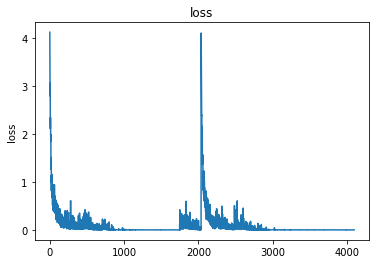

In [75]:
a = torch.tensor(crnn_loss)
a = a.cpu()
plt.plot(a)
plt.ylabel("loss")
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

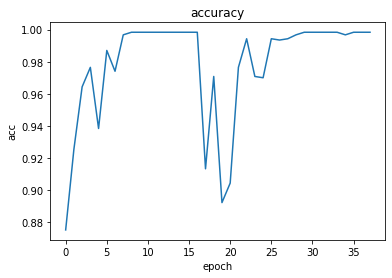

In [76]:
plt.plot(crnn_acc)
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title('accuracy')

In [81]:
np.max(crnn_acc)

0.9983779399837794

# 预测代码

In [135]:
def predict(net, data):
    print("目标标签",data[1].argmax())
    print(net(data[0].unsqueeze(0).cuda(), decode=False).argmax(axis=-1)[1]

In [130]:
net = load_model(snapshot='crnn_resnet18__best')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(55)


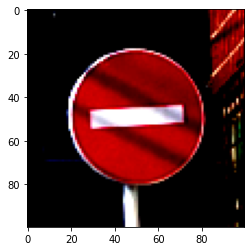

In [101]:
a = test_dataset[0][0]
a = a.permute(1,2,0)
plt.imshow(a)
print(np.argmax(test_dataset[0][1]))

In [137]:
predict(net,test_dataset[0])

目标标签 tensor(55)


tensor([55], device='cuda:0')

In [138]:
predict(net,test_dataset[200])

目标标签 tensor(30)


tensor([30], device='cuda:0')